In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install biopython

In [3]:
# Install DeepSig
!pip install deepsig-biocomp

In [4]:
import shutil
import os

# Define the directory path
directory_path = '/content/deepsig'

# Remove the directory if it exists
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)

In [5]:
# Clone the DeepSig repository and export DEEPSIG_ROOT
!git clone https://github.com/BolognaBiocomp/deepsig.git
%cd deepsig
import os
os.environ['DEEPSIG_ROOT'] = os.getcwd()

Cloning into 'deepsig'...
remote: Enumerating objects: 555, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 555 (delta 68), reused 105 (delta 64), pack-reused 434
Receiving objects: 100% (555/555), 43.26 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (188/188), done.
/content/deepsig


In [6]:

!deepsig -f "/content/drive/MyDrive/LB2/benchmarking.fasta" -o "/content/drive/MyDrive/LB2/benchmarking_deepsig.txt" -k euk

!deepsig -f "/content/drive/MyDrive/LB2/second_try/cross_validation/test_set.fasta" -o "/content/drive/MyDrive/LB2/test_deepsig.txt" -k euk

2024-07-19 23:20:56.920028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 23:20:56.920157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 23:20:56.928156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 23:20:56.960534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 23:20:58.601089: W tensorflow/compiler/tf2

In [22]:
import pandas as pd

# Define paths for the result files of DeepSig
result_benchmarking = '/content/drive/MyDrive/LB2/benchmarking_deepsig.txt'
result_test = '/content/drive/MyDrive/LB2/test_deepsig.txt'

# Function to process the DeepSig results
def process_deepsig_results(file_path):
    # Read the file into a DataFrame
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Convert the first column to string
    df[0] = df[0].astype(str)

    # Extract the entry from the first column
    df['Entry'] = df[0].apply(lambda x: x.split('|')[1] if '|' in x else x)

    # Map 'Signal peptide' to 1 and 'Chain' to 0
    df['Label'] = df[2].apply(lambda x: 1 if x == 'Signal peptide' else 0)

    # Create the final DataFrame with the required columns
    final_df = df[['Entry', 2, 'Label']]
    final_df.columns = ['Entry', 'S_C', 'Label']

    return final_df

# Process the results
benchmark_df = process_deepsig_results(result_benchmarking)
test_df = process_deepsig_results(result_test)

# Display the first few rows of each DataFrame
print("Benchmarking DataFrame from Deepsig:")
print(benchmark_df.head())

print("\nTest DataFrame from Deepsig:")
print(test_df.head())


Benchmarking DataFrame from Deepsig:
    Entry    S_C  Label
0  Q9VCU5  Chain      0
1  Q8K2H6  Chain      0
2  Q9LKA0  Chain      0
3  Q501D2  Chain      0
4  Q06811  Chain      0

Test DataFrame from Deepsig:
    Entry             S_C  Label
0  Q9LXD6  Signal peptide      1
1  Q9LXD6           Chain      0
2  Q05928  Signal peptide      1
3  Q05928           Chain      0
4  P67788  Signal peptide      1


In [41]:
import pandas as pd
test_csv_path = '/content/drive/MyDrive/LB2/second_try/cross_validation/training_combined_data.csv'
test_df_filtered = pd.read_csv(test_csv_path, sep=",")[['Entry', 'label']]
print("\nTest DataFrame from our known data:")
print(test_df_filtered.head())

import pandas as pd
benchmarking_csv_path = '/content/drive/MyDrive/LB2/benchmarking.tsv'
benchmarking_df_filtered = pd.read_csv(benchmarking_csv_path, sep=",")[['Entry', 'label']]
print("\nBenchmarking DataFrame from our known data:")
print(benchmarking_df_filtered.head())


Test DataFrame from our known data:
    Entry  label
0  O35914      0
1  D3ZKB9      0
2  Q59UY7      0
3  Q1PE39      0
4  Q9ZUX4      0

Benchmarking DataFrame from our known data:
    Entry  label
0  Q9VCU5      0
1  Q8K2H6      0
2  Q9LKA0      0
3  Q501D2      0
4  Q06811      0


In [39]:
import pandas as pd
benchmarking_csv_path = '/content/drive/MyDrive/LB2/benchmarking.tsv'
benchmarking_df_filtered = pd.read_csv(benchmarking_csv_path, sep=",")[['Entry', 'label']]
print("\nbenchmarking DataFrame from our known data:")
print(benchmarking_df_filtered.head())


benchmarking DataFrame from our known data:
    Entry  label
0  Q9VCU5      0
1  Q8K2H6      0
2  Q9LKA0      0
3  Q501D2      0
4  Q06811      0


In [43]:
# Import necessary modules
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define paths for the result files of DeepSig and the test CSV file
result_benchmarking = '/content/drive/MyDrive/LB2/benchmarking_deepsig.txt'
result_test = '/content/drive/MyDrive/LB2/test_deepsig.txt'
test_csv_path = '/content/drive/MyDrive/LB2/second_try/cross_validation/training_combined_data.csv'
benchmarking_csv_path = '/content/drive/MyDrive/LB2/benchmarking.tsv'

# Function to process the DeepSig results
def process_deepsig_results(file_path):
    # Read the file into a DataFrame
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Convert the first column to string
    df[0] = df[0].astype(str)

    # Extract the entry from the first column
    df['Entry'] = df[0].apply(lambda x: x.split('|')[1] if '|' in x else x)

    # Map 'Signal peptide' to 1 and 'Chain' to 0
    df['Label'] = df[2].apply(lambda x: 1 if x == 'Signal peptide' else 0)

    # Create the final DataFrame with the required columns
    final_df = df[['Entry', 2, 'Label']]
    final_df.columns = ['Entry', 'S_C', 'Label']

    return final_df

# Process the results
benchmark_df = process_deepsig_results(result_benchmarking)
test_df = process_deepsig_results(result_test)

# Display the first few rows of each DataFrame
print("Benchmarking DataFrame:")
print(benchmark_df.head())

print("\nTest DataFrame:")
print(test_df.head())

# Load the test CSV to get the true labels
test_df_filtered = pd.read_csv(test_csv_path, sep=",")[['Entry', 'label']]
print("\nTest DataFrame from our known data:")
print(test_df_filtered.head())

# Load the benchmarking CSV to get the true labels
benchmarking_df_filtered = pd.read_csv(benchmarking_csv_path, sep=",")[['Entry', 'label']]
print("\nBenchmarking DataFrame from our known data:")
print(benchmarking_df_filtered.head())

# Merge true labels with predictions for evaluation
benchmarking_merged_df = benchmark_df.merge(benchmarking_df_filtered, on='Entry', suffixes=('_pred', '_true'))
test_merged_df = test_df.merge(test_df_filtered, on='Entry', suffixes=('_pred', '_true'))

# Evaluate predictions
benchmarking_y_true = benchmarking_merged_df['label']
benchmarking_y_pred = benchmarking_merged_df['Label']
test_y_true = test_merged_df['label']
test_y_pred = test_merged_df['Label']

# Calculate performance metrics for benchmarking set
benchmark_accuracy = accuracy_score(benchmarking_y_true, benchmarking_y_pred)
benchmark_precision = precision_score(benchmarking_y_true, benchmarking_y_pred)
benchmark_recall = recall_score(benchmarking_y_true, benchmarking_y_pred)
benchmark_f1 = f1_score(benchmarking_y_true, benchmarking_y_pred)

# Calculate performance metrics for test set
test_accuracy = accuracy_score(test_y_true, test_y_pred)
test_precision = precision_score(test_y_true, test_y_pred)
test_recall = recall_score(test_y_true, test_y_pred)
test_f1 = f1_score(test_y_true, test_y_pred)

# Print performance metrics
print('Benchmarking Set Performance:')
print(f'Accuracy: {benchmark_accuracy}')
print(f'Precision: {benchmark_precision}')
print(f'Recall: {benchmark_recall}')
print(f'F1 Score: {benchmark_f1}')

print('Test Set Performance:')
print(f'Accuracy: {test_accuracy}')
print(f'Precision: {test_precision}')
print(f'Recall: {test_recall}')
print(f'F1 Score: {test_f1}')

Benchmarking DataFrame:
    Entry    S_C  Label
0  Q9VCU5  Chain      0
1  Q8K2H6  Chain      0
2  Q9LKA0  Chain      0
3  Q501D2  Chain      0
4  Q06811  Chain      0

Test DataFrame:
    Entry             S_C  Label
0  Q9LXD6  Signal peptide      1
1  Q9LXD6           Chain      0
2  Q05928  Signal peptide      1
3  Q05928           Chain      0
4  P67788  Signal peptide      1

Test DataFrame from our known data:
    Entry  label
0  O35914      0
1  D3ZKB9      0
2  Q59UY7      0
3  Q1PE39      0
4  Q9ZUX4      0

Benchmarking DataFrame from our known data:
    Entry  label
0  Q9VCU5      0
1  Q8K2H6      0
2  Q9LKA0      0
3  Q501D2      0
4  Q06811      0
Benchmarking Set Performance:
Accuracy: 0.9130216189039718
Precision: 0.912751677852349
Recall: 0.4594594594594595
F1 Score: 0.6112359550561798
Test Set Performance:
Accuracy: 0.9270833333333334
Precision: 0.9338624338624338
Recall: 0.47638326585695007
F1 Score: 0.6309204647006256


Confusion Matrix (Test Set) - True Positives (TP): 353
Confusion Matrix (Test Set) - True Negatives (TN): 4898
Confusion Matrix (Test Set) - False Positives (FP): 25
Confusion Matrix (Test Set) - False Negatives (FN): 388
Confusion Matrix (Benchmarking Set) - True Positives (TP): 136
Confusion Matrix (Benchmarking Set) - True Negatives (TN): 1680
Confusion Matrix (Benchmarking Set) - False Positives (FP): 13
Confusion Matrix (Benchmarking Set) - False Negatives (FN): 160


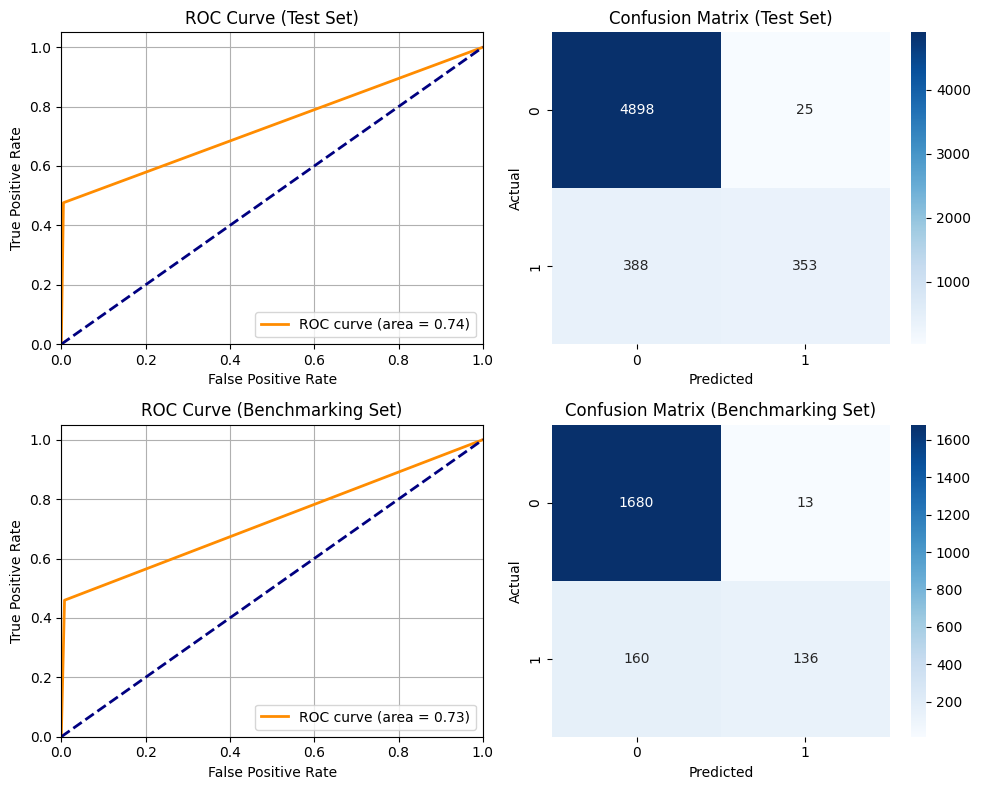

In [46]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    tn, fp, fn, tp = cm.ravel()
    print(f'{title} - True Positives (TP): {tp}')
    print(f'{title} - True Negatives (TN): {tn}')
    print(f'{title} - False Positives (FP): {fp}')
    print(f'{title} - False Negatives (FN): {fn}')

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, ax, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True)

# Placeholder for probabilities since DeepSig results might not provide them
test_y_scores = test_y_pred  # Replace with actual probabilities if available
benchmarking_y_scores = benchmarking_y_pred  # Replace with actual probabilities if available

# Create subplots for visualizations
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Test set visualizations
plot_roc_curve(test_y_true, test_y_scores, ax=axes[0, 0], title='ROC Curve (Test Set)')
plot_confusion_matrix(test_y_true, test_y_pred, ax=axes[0, 1], title='Confusion Matrix (Test Set)')

# Benchmarking set visualizations
plot_roc_curve(benchmarking_y_true, benchmarking_y_scores, ax=axes[1, 0], title='ROC Curve (Benchmarking Set)')
plot_confusion_matrix(benchmarking_y_true, benchmarking_y_pred, ax=axes[1, 1], title='Confusion Matrix (Benchmarking Set)')

# Adjust layout
plt.tight_layout()
plt.show()